In [1]:
import numpy as np
import torch
import tensorflow as tf

In [2]:
torch.set_default_dtype(torch.float64)
tf.keras.config.set_floatx('float64')

In [3]:
def add_to_class(Class):  
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

# Create dataset

Dataset
$$
\begin{align*}
\mathbf{X} &\in \mathbb{R}^{M \times N} \\
\mathbf{y} &\in \mathbb{R}^{M}
\end{align*}
$$

In [4]:
from sklearn.datasets import make_regression
import random

M: int = 100 #number of samples
N: int = 4 #number of features

TRUE_B = random.random() * 10

X, Y, TRUE_W = make_regression(n_samples=M, n_features=N, n_targets=1,
                               n_informative=N-1, bias=TRUE_B, noise=1, coef=True)

print(X.shape)
print(Y.shape)
print(TRUE_W.shape)

(100, 4)
(100,)
(4,)


# Model

## weights

Trainables parameters
$$
\begin{align*}
\mathbf{w} &\in \mathbb{R}^{N} \\
b &\in \mathbb{R}
\end{align*}
$$

In [5]:
class SimpleLinearRegression:
    def __init__(self, num_features: int, penalty: float) -> None:
        self.w = torch.randn(num_features)
        self.b = torch.randn(1)
        self.lambd = penalty

    def copy_params(self, tf_model) -> None:
        """Copy the parameters from a TensorFlow model to this PyTorch model.

        Args:
            tf_model: A TensorFlow model from which to copy the parameters.
            penalty: Penalty hyperparemeter for L2 regularization.

        Returns:
            None
        """
        self.w.copy_(torch.tensor(tf_model.weights[0].numpy()[:,0]))
        self.b.copy_(torch.tensor(tf_model.weights[1].numpy()))

## weighted sum

$$
\begin{align*}
\mathbf{\hat{y}}(\mathbf{X}) = \mathbf{X}\mathbf{w} + b \\
\mathbf{\hat{y}} : \mathbb{R}^{M \times N} \rightarrow 
\mathbb{R}^{M}
\end{align*}
$$

In [6]:
@add_to_class(SimpleLinearRegression)
def predict(self, x: torch.Tensor) -> torch.Tensor:
    """Predict the output for input x.

    Args:
        x: Input tensor of shape (n_samples, num_features).

    Returns:
        y_pred: Predicted output tensor of shape (n_samples,).
    """
    y_pred = torch.matmul(x, self.w) + self.b
    return y_pred

## MSE with weight decay

Loss function: Mean Squared Error with weight decay:
$$
\begin{align*}
L(\mathbf{\hat{y}}) &= \frac{1}{M} \sum_{i=1}^{M}(
    \hat{y}_i - \mathbf{\mathbb{y}}_i)^{2} 
+ \lambda \sum_{j=0}^{N} w_{j}^{2} \\
L &: \mathbb{R}^{M} \rightarrow \mathbb{R}
\end{align*}
$$
Vectorized form:
$$
\begin{align*}
L(\mathbf{\hat{y}}) &= \frac{1}{M} 
    \left\| \mathbf{e} \right\|_{2}^2 
+ \lambda \left\| \boldsymbol{w} \right\|_{2}^{2} \\
&= \frac{1}{M} (\mathbf{e}^T \mathbf{e}) + \lambda (\mathbf{w}^T \mathbf{w}) \\
\mathbf{e} &:= \mathbf{\hat{y}} - \mathbf{y}
\end{align*}
$$
where $\lambda$ is called regularization or penalty hyperparameter. <br>
**Note**: this type of weight decay is called $\mathit{L}_2$ Regularization. <br>
**Remark**: weight regularization only affect on $\mathbf{w}$ and not on $b$.

In [7]:
@add_to_class(SimpleLinearRegression)
def evaluate(self, x: torch.Tensor, y_true: torch.Tensor) -> float:
    """Evaluate the model on input x and target y_true using MSE.

    Args:
        x: Input tensor of shape (n_samples, num_features).
        y_true: Target tensor of shape (n_samples,).

    Returns:
        loss: MSE loss between predictions and true values.
    """
    y_pred = self.predict(x)
    e = y_pred - y_true
    loss = (e**2).sum()
    return loss.item() / len(y_true)

@add_to_class(SimpleLinearRegression)
def weight_decay_loss(self, x: torch.Tensor, y_true: torch.Tensor) -> float:
    """Evaluate the model on input x and target y_true using MSE with L2 regularization
    
    Args:
        x: Input tensor of shape (n_samples, num_features).
        y_true: Target tensor of shape (n_samples,)

    Returns:
        loss: MSE loss with L2 regularization between predictions and true values.
    """
    loss = self.evaluate(x, y_true)
    return loss + self.lambd * (self.w**2).sum().item()

# Gradient with $\mathit{L}_{2}$ regularization

$$
\frac{\partial L}{\partial \mathbf{w}} =
\frac{\partial}{\partial \mathbf{w}} \left(
    {\color{cyan} \frac{1}{M} (\mathbf{e}^T \mathbf{e})}
\right) 
+ \frac{\partial}{\partial \mathbf{w}} \left(
    {\color{orange} \lambda (\mathbf{w}^T \mathbf{w})}
\right) \\
$$
where the ${\color{cyan} \text{cyan part}}$ is the derivative of the original MSE loss function and the ${\color{orange} \text{orange part}}$ is the derivative of the regularizer. <br>
Therefore
$$
\frac{\partial}{\partial \mathbf{w}} \left(
    \frac{1}{M} (\mathbf{e}^T \mathbf{e})
\right) = \frac{2}{M} (\mathbf{\hat{y}} - \mathbf{y}) \mathbf{X}
$$
and
$$
\frac{\partial}{\partial \mathbf{w}} \left(
    \lambda (\mathbf{w}^T \mathbf{w})
\right) = 2\lambda \mathbf{w}
$$

## summary

$$
\frac{\partial L}{\partial \mathbf{w}} =
{\color{cyan} \frac{2}{M} (\mathbf{\hat{y}} - \mathbf{y}) \mathbf{X}}
+ {\color{orange} 2\lambda \mathbf{w}}
$$
**Note**: still that $\frac{\partial L}{\partial \mathbf{w}} \in \mathbb{R}^{N}$.

## Parameters update

$$
\begin{align}
\mathbf{w} &\leftarrow \mathbf{w} - \eta \nabla_{\mathbf{w}} L =
\mathbf{w} - \eta \left(
    \frac{2}{M} (\mathbf{\hat{y}} - \mathbf{y}) \mathbf{X}
    + 2\lambda \mathbf{w}
\right) \\
b &\leftarrow b - \eta \nabla_{b} L =
b - \eta \left(
    \frac{2}{M} (\mathbf{\hat{y}} - \mathbf{y}) \boldsymbol{1}
\right)
\end{align}
$$

In [8]:
@add_to_class(SimpleLinearRegression)
def update(self, x: torch.Tensor, y_true: torch.Tensor,
           y_pred: torch.Tensor, lr: float) -> None:
    """Update the model parameters.

    Args:
        x: Input tensor of shape (n_samples, num_features).
        y_true: Target tensor of shape (n_samples,).
        y_pred: Predicted output tensor of shape (n_samples,).
        lr: Learning rate.
    """
    delta = 2 * (y_pred - y_true) / len(y_true)
    self.b -= lr * delta.sum()
    self.w -= lr * (torch.matmul(delta, x) + 2 * self.lambd * self.w)

## Fit (Gradient descent)

In [9]:
@add_to_class(SimpleLinearRegression)
def fit(self, x_train: torch.Tensor, y_train: torch.Tensor, 
        epochs: int, lr: float, batch_size: int, 
        x_valid: torch.Tensor, y_valid: torch.Tensor) -> None:
    """fit the model using gradient descent.

    Args:
        x_train: Input tensor of shape (n_samples, num_features).
        y_train: Target tensor of shape (n_samples,).
        epochs: Number of epochs to train.
        lr: learning rate (0, 1).
        batch_size: Int number of batch.
        x_valid: Input tensor of shape (n_valid_samples, num_features).
        y_valid: Input tensor of shape (n_valid_samples,).
    """
    self.loss_fit = []
    self.loss_fit_v = []
    for epoch in range(epochs):
        loss = 0
        num_batch = 0
        for batch in range(0, len(y_train), batch_size):
            num_batch += 1
            x_b = x_train[batch:batch+batch_size]
            y_b = y_train[batch:batch+batch_size]

            y_pred = self.predict(x_b)
            loss += self.weight_decay_loss(x_b, y_b)

            self.update(x_b, y_b, y_pred, lr)

        self.loss_fit.append(loss / num_batch)
        self.loss_fit_v.append(self.weight_decay_loss(x_valid, y_valid))

        loss = round(self.loss_fit[-1], 4)
        loss_v = round(self.loss_fit_v[-1], 4)
        print(f'epoch: {epoch} - MSE: {loss} - MSE_v: {loss_v}')

# Scratch vs TF

## Train and validation data

In [10]:
X_train, Y_train = torch.tensor(X[:85]), torch.tensor(Y[:85])
X_valid, Y_valid = torch.tensor(X[85:]), torch.tensor(Y[85:])

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

torch.Size([85, 4]) torch.Size([85])
torch.Size([15, 4]) torch.Size([15])


## Hyperparameters

In [11]:
LR = 0.001
EPOCHS = 6
BATCH = len(X_train) // 3
LAMBD = 0.03

## models

### TF model

In [12]:
TFModel = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, 
                          activation='linear',
                          kernel_regularizer = tf.keras.regularizers.L2(
                              l2=LAMBD
                          ))
])

TFModel.compile(
    loss = tf.keras.losses.MSE,
    optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
)

TFModel.evaluate(X[:1], Y[:1])

TFModel.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 2842.1938


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (40.00 B)

 Trainable params: 5 (40.00 B)

 Non-trainable params: 0 (0.00 B)

### Our model

In [13]:
model = SimpleLinearRegression(N, LAMBD)
model.copy_params(TFModel)

## Comparisons

In [14]:
def error(tensor_true, tensor_pred) -> float:
    """
     Calculates the percentage error between two tensors or floats.

     If the arguments are simple floats or ints, calculate the percentage error between them.
     If the arguments are Numpy ndarray and PyTorch tensor, calculate the percentage error between them.
     If the argumens are PyTorch tensors, calculate the percentage error between them.

     Args:
         tensor_true: The true tensor or true float.
         pred_tensor: The predicted tensor or the predicted float.

     Returns:
         The percentage error between the tensors or floats.
     """
    if isinstance(tensor_true, (float, int)) and isinstance(tensor_pred, (float, int)):
        return np.abs(tensor_true - tensor_pred) / np.abs(tensor_true) * 100
    elif type(tensor_true) is np.ndarray and type(tensor_pred) is torch.Tensor:
        e = np.abs(tensor_true[:,0] - tensor_pred.numpy()) / np.abs(tensor_true[:,0])
        return np.mean(e) * 100
    e = torch.abs(tensor_true - tensor_pred) / torch.abs(tensor_true)
    return torch.mean(e) * 100

### predict

In [15]:
tf_predict = TFModel.predict(X_train, batch_size=len(X_train))
predict = model.predict(X_train)

error(tf_predict, predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


1.0214204438807779e-14

### MSE without regularizer

In [16]:
tf_predict = TFModel.evaluate(X_train, Y_train, batch_size=len(X_train))
predict = model.evaluate(X_train, Y_train)

error(tf_predict, predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 12186.2334


0.00040114625180575665

### MSE with regularizer

In [17]:
tf_predict = TFModel.evaluate(X_train, Y_train, batch_size=len(X_train))
predict = model.weight_decay_loss(X_train, Y_train)

error(tf_predict, predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 12186.2334


0.0

### fit

In [18]:
TFModel.fit(X_train, Y_train, batch_size=BATCH, epochs=EPOCHS,
            shuffle=False, validation_data=(X_valid, Y_valid))

Epoch 1/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 10654.5059 - val_loss: 16566.2891
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 10551.3672 - val_loss: 16437.4004
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 10449.3809 - val_loss: 16309.6729
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 10348.5332 - val_loss: 16183.0928
Epoch 5/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 10248.8096 - val_loss: 16057.6494
Epoch 6/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 10150.1973 - val_loss: 15933.3320


In [19]:
TFModel.history.history['loss']

[9221.070994125188,
 9130.885357530797,
 9041.719466118839,
 8953.560876145739,
 8866.397305103445,
 8780.216629527893]

In [20]:
model.fit(X_train, Y_train, EPOCHS, LR, BATCH, X_valid, Y_valid)

epoch: 0 - MSE: 9221.071 - MSE_v: 16566.2885
epoch: 1 - MSE: 9130.8854 - MSE_v: 16437.4005
epoch: 2 - MSE: 9041.7195 - MSE_v: 16309.6725
epoch: 3 - MSE: 8953.5609 - MSE_v: 16183.0927
epoch: 4 - MSE: 8866.3973 - MSE_v: 16057.6497
epoch: 5 - MSE: 8780.2166 - MSE_v: 15933.3319


In [21]:
tf_predict = TFModel.weights[0].numpy()
predict = model.w

error(tf_predict, predict)

9.56218589342575e-15

In [22]:
tf_predict = TFModel.weights[1].numpy()[0]
predict = model.b.item()

error(tf_predict, predict)

0.0

# Diferents $\lambda$ case

## creating 3 models with same parameters initialization

Models
1. Underfitting (Excesive $\lambda$)
2. Appropiate weight decay (Medium $\lambda$)
3. Overfitting ($\lambda \rightarrow 0$)

In [23]:
import matplotlib.pyplot as plt

In [24]:
model1 = SimpleLinearRegression(N, 0)

model2 = SimpleLinearRegression(N, 0.03)
model2.w.copy_(model1.w)
model2.b.copy_(model1.b)

model3 = SimpleLinearRegression(N, 1)
model3.w.copy_(model1.w)
model3.b.copy_(model1.b)

tensor([0.0535])

In [25]:
model1.fit(X_train, Y_train, 20, 0.001, 1, X_valid, Y_valid)

epoch: 0 - MSE: 10703.7776 - MSE_v: 13394.6468
epoch: 1 - MSE: 8175.4598 - MSE_v: 10813.1925
epoch: 2 - MSE: 6293.7669 - MSE_v: 8764.058
epoch: 3 - MSE: 4881.9814 - MSE_v: 7127.9235
epoch: 4 - MSE: 3814.1687 - MSE_v: 5814.7321
epoch: 5 - MSE: 3000.054 - MSE_v: 4755.8868
epoch: 6 - MSE: 2374.5146 - MSE_v: 3898.6739
epoch: 7 - MSE: 1890.2552 - MSE_v: 3202.2461
epoch: 8 - MSE: 1512.6839 - MSE_v: 2634.704
epoch: 9 - MSE: 1216.3127 - MSE_v: 2170.9571
epoch: 10 - MSE: 982.2187 - MSE_v: 1791.1413
epoch: 11 - MSE: 796.2443 - MSE_v: 1479.4377
epoch: 12 - MSE: 647.7145 - MSE_v: 1223.1822
epoch: 13 - MSE: 528.5183 - MSE_v: 1012.1889
epoch: 14 - MSE: 432.4459 - MSE_v: 838.2316
epoch: 15 - MSE: 354.7082 - MSE_v: 694.6421
epoch: 16 - MSE: 291.5859 - MSE_v: 575.9985
epoch: 17 - MSE: 240.171 - MSE_v: 477.8794
epoch: 18 - MSE: 198.1758 - MSE_v: 396.6706
epoch: 19 - MSE: 163.7898 - MSE_v: 329.4117


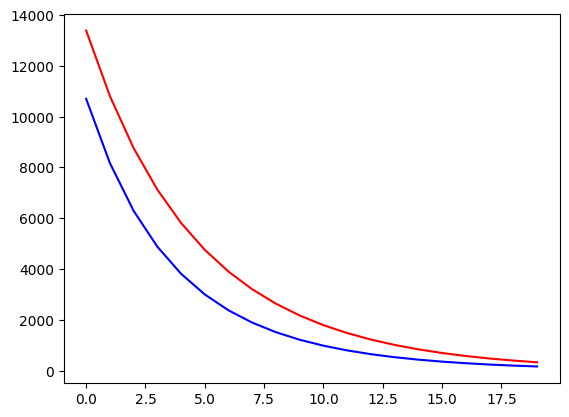

In [26]:
plt.plot(range(0, len(model1.loss_fit)), model1.loss_fit, color='blue')
plt.plot(range(0, len(model1.loss_fit_v)), model1.loss_fit_v, color='red')
plt.show()

In [27]:
model2.fit(X_train, Y_train, 20, 0.001, 1, X_valid, Y_valid)

epoch: 0 - MSE: 10708.5343 - MSE_v: 13411.1716
epoch: 1 - MSE: 8204.5711 - MSE_v: 10866.9492
epoch: 2 - MSE: 6359.9704 - MSE_v: 8865.1854
epoch: 3 - MSE: 4990.2357 - MSE_v: 7279.9214
epoch: 4 - MSE: 3964.9379 - MSE_v: 6017.0617
epoch: 5 - MSE: 3191.3381 - MSE_v: 5005.6702
epoch: 6 - MSE: 2603.0855 - MSE_v: 4191.7937
epoch: 7 - MSE: 2152.3933 - MSE_v: 3534.0477
epoch: 8 - MSE: 1804.603 - MSE_v: 3000.4328
epoch: 9 - MSE: 1534.3933 - MSE_v: 2566.0222
epoch: 10 - MSE: 1323.1245 - MSE_v: 2211.2645
epoch: 11 - MSE: 1156.9694 - MSE_v: 1920.7283
epoch: 12 - MSE: 1025.591 - MSE_v: 1682.1649
epoch: 13 - MSE: 921.2018 - MSE_v: 1485.8024
epoch: 14 - MSE: 837.8906 - MSE_v: 1323.809
epoch: 15 - MSE: 771.1372 - MSE_v: 1189.8825
epoch: 16 - MSE: 717.4607 - MSE_v: 1078.9329
epoch: 17 - MSE: 674.1627 - MSE_v: 986.8358
epoch: 18 - MSE: 639.1384 - MSE_v: 910.2399
epoch: 19 - MSE: 610.7362 - MSE_v: 846.4145


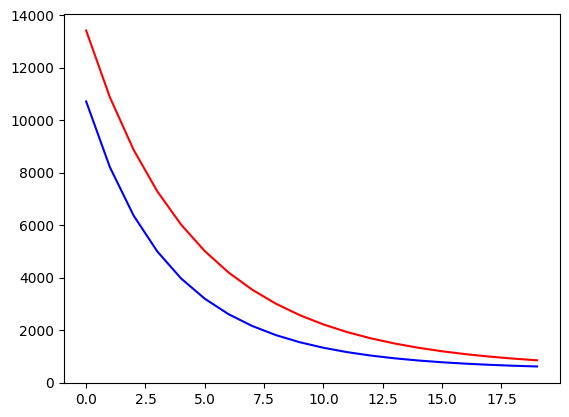

In [28]:
plt.plot(range(0, len(model2.loss_fit)), model2.loss_fit, color='blue')
plt.plot(range(0, len(model2.loss_fit_v)), model2.loss_fit_v, color='red')
plt.show()

In [29]:
model3.fit(X_train, Y_train, 20, 0.001, 1, X_valid, Y_valid)

epoch: 0 - MSE: 10850.7836 - MSE_v: 13895.2384
epoch: 1 - MSE: 9003.7504 - MSE_v: 12305.2221
epoch: 2 - MSE: 8025.0273 - MSE_v: 11366.8932
epoch: 3 - MSE: 7503.8508 - MSE_v: 10794.4997
epoch: 4 - MSE: 7224.8871 - MSE_v: 10432.5929
epoch: 5 - MSE: 7074.7691 - MSE_v: 10195.2782
epoch: 6 - MSE: 6993.541 - MSE_v: 10034.1598
epoch: 7 - MSE: 6949.3413 - MSE_v: 9921.3116
epoch: 8 - MSE: 6925.1528 - MSE_v: 9840.1569
epoch: 9 - MSE: 6911.839 - MSE_v: 9780.5346
epoch: 10 - MSE: 6904.4682 - MSE_v: 9735.9961
epoch: 11 - MSE: 6900.3633 - MSE_v: 9702.3026
epoch: 12 - MSE: 6898.0634 - MSE_v: 9676.5727
epoch: 13 - MSE: 6896.7666 - MSE_v: 9656.7872
epoch: 14 - MSE: 6896.0303 - MSE_v: 9641.4948
epoch: 15 - MSE: 6895.6091 - MSE_v: 9629.6299
epoch: 16 - MSE: 6895.3659 - MSE_v: 9620.3977
epoch: 17 - MSE: 6895.2239 - MSE_v: 9613.1976
epoch: 18 - MSE: 6895.14 - MSE_v: 9607.572
epoch: 19 - MSE: 6895.0894 - MSE_v: 9603.1694


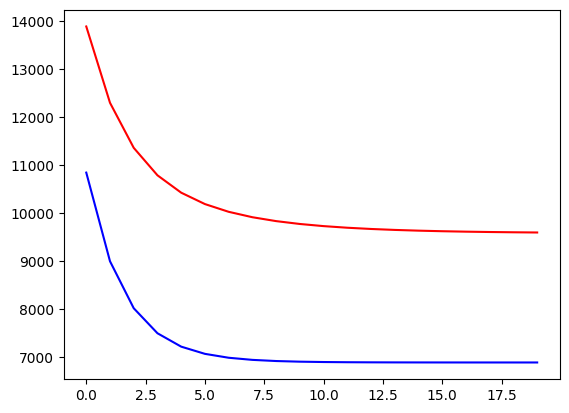

In [30]:
plt.plot(range(0, len(model3.loss_fit)), model3.loss_fit, color='blue')
plt.plot(range(0, len(model3.loss_fit_v)), model3.loss_fit_v, color='red')
plt.show()